In [137]:
import networkx as nx
import matplotlib.pyplot as plt
import random
import networkx as nx
import random
from sklearn.model_selection import train_test_split

In [130]:
def visualize_graph_pair(graph1: nx.Graph, graph2: nx.Graph, is_isomorphic: bool) -> None:
    plt.figure(figsize=(12, 6))
    
    # Plot graph 1
    plt.subplot(121)
    nx.draw(graph1, with_labels=False, font_weight='bold', node_color='skyblue', node_size=6)
    plt.title("Graph 1")

    # Plot graph 2
    plt.subplot(122)
    nx.draw(graph2, with_labels=False, font_weight='bold', node_color='lightgreen', node_size=6)
    plt.title("Graph 2")

    # Show isomorphism status
    plt.suptitle(f"Isomorphic: {is_isomorphic}, Number of nodes: {graph1.number_of_nodes()}")

    plt.show()

In [92]:
def generate_isomorphism_with_permutation(G: nx.Graph) -> nx.Graph:

    # Generate a random permutation σ of the vertex set V
    V = list(G.nodes())
    random.shuffle(V)
    permutation = {original: new for original, new in zip(G.nodes(), V)}
    # Create the graph G' with edges E' based on the permutation σ
    G_prime = nx.relabel_nodes(G, permutation)
    while not nx.is_isomorphic(G, G_prime) and not nx.is_connected(G_prime):
        random.shuffle(V)
        permutation = {original: new for original, new in zip(G.nodes(), V)}
        G_prime = nx.relabel_nodes(G, permutation)

    return G_prime

In [93]:
# Function to generate a non-isomorphic graph pair with the same number of vertices
def generate_non_isomorphic_graph(base_graph: nx.Graph, num_nodes: int, edge_prob = 0.5) -> nx.Graph:
    # Generate a non-isomorphic graph with the same number of nodes
    non_iso_graph = nx.gnp_random_graph(num_nodes, edge_prob)
    while nx.is_isomorphic(base_graph, non_iso_graph) or nx.is_connected(non_iso_graph) == False:
        non_iso_graph = nx.gnp_random_graph(num_nodes, edge_prob)
        
    return non_iso_graph

In [94]:
def generate_connected_graph(num_nodes: int, edge_prob: float) -> nx.Graph:
    G = nx.gnp_random_graph(num_nodes, edge_prob)
    while min(dict(nx.degree(G)).values()) == 0:  # Check for isolated vertices
        G = nx.gnp_random_graph(num_nodes, edge_prob)
    return G

In [95]:


# Function to generate a graph pair
def generate_graph_pair(num_nodes: str, is_isomorphic: bool, edge_prob=0.5) -> tuple[nx.Graph, nx.Graph, bool]:
    if num_nodes < 3:
        raise ValueError("Number of nodes must be at least 3")
    
    G = generate_connected_graph(num_nodes, edge_prob) 

    if is_isomorphic:
        G_prime = generate_isomorphism_with_permutation(G)
    else:
        G_prime = generate_non_isomorphic_graph(G, num_nodes, edge_prob)

    return G, G_prime, is_isomorphic


False


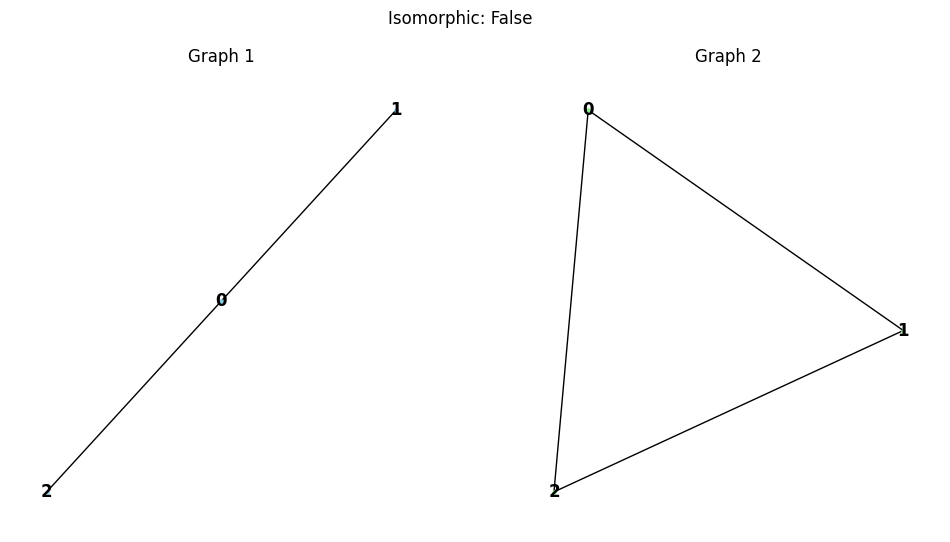

In [64]:
# Generate an example pair of graphs
is_isomorphic = False
example_pair = generate_graph_pair(3, is_isomorphic)  # Change to False to generate non-isomorphic pair
graph1, graph2, is_isomorphic = example_pair
print(nx.is_isomorphic(graph1, graph2))

# Visualize the generated graphs
visualize_graph_pair(graph1, graph2, is_isomorphic)

In [118]:
from math import floor
def create_dataset(max_nodes: int, generation_proportion: int, edge_prob: float) -> list[tuple[nx.Graph, nx.Graph, bool]]:
    dataset = []
    for num_nodes in range(3, max_nodes + 1):
        num_graphs = floor(generation_proportion * num_nodes)
        print(f"Generating {num_graphs} graphs with {num_nodes} nodes")
        for _ in range(num_graphs):
            is_isomorphic = random.choice([True, False])
            graph_pair = generate_graph_pair(num_nodes, is_isomorphic, edge_prob)
            dataset.append(graph_pair)
    return dataset

In [119]:
dataset = create_dataset(10, 1, 0.5)

Generating 3 graphs with 3 nodes
Generating 4 graphs with 4 nodes
Generating 5 graphs with 5 nodes
Generating 6 graphs with 6 nodes
Generating 7 graphs with 7 nodes
Generating 8 graphs with 8 nodes
Generating 9 graphs with 9 nodes
Generating 10 graphs with 10 nodes


In [120]:
len(dataset)

52

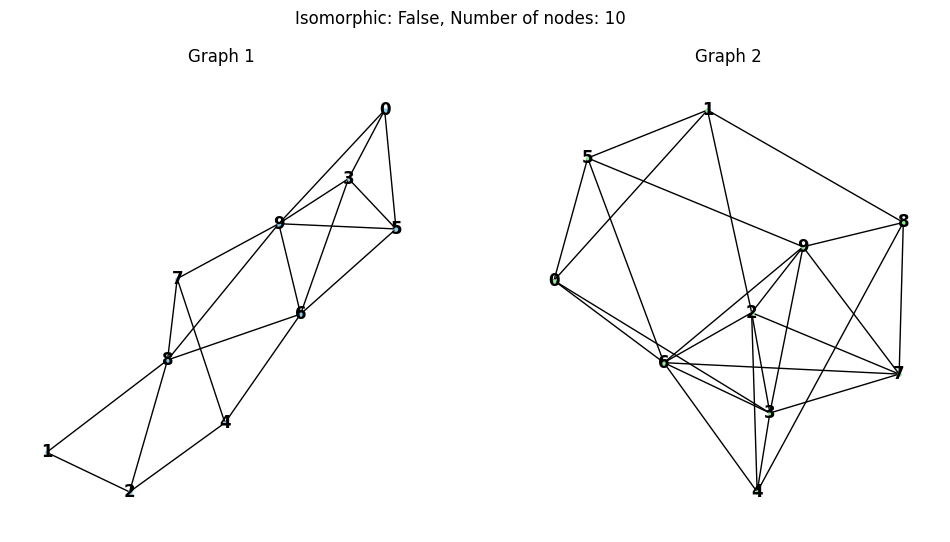

In [129]:
visualize_graph_pair(*dataset[51])

In [132]:
# Separate graph pairs and labels
graph_pairs = [(g1, g2) for g1, g2, _ in dataset]
labels = [label for _, _, label in dataset]


In [ ]:
import os
import readARGdbFiles
import load_adj_mat
import get_graph_pairs_and_labels
import Graph_Isomorphism_Network
import numpy as np
import dgl
import tensorflow as tf
import numpy as np
from dgl.nn import GraphConv
import torch
import dgl
import torch
import torch.nn as nn
from dgl.nn import GraphConv
import networkx as nx
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

In [140]:
def convert_to_dgl(graph):
    # Convert a NetworkX graph to a DGL graph
    return dgl.from_networkx(graph)

# Convert each graph in the pairs to DGL format
dgl_graph_pairs = [(convert_to_dgl(g1), convert_to_dgl(g2)) for g1, g2 in graph_pairs]


In [141]:
train_pairs, test_pairs, train_labels, test_labels = train_test_split(dgl_graph_pairs, labels, test_size=0.2, random_state=42)

In [142]:
class GIN(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(GIN, self).__init__()
        self.conv1 = GraphConv(input_dim, hidden_dim)
        self.conv2 = GraphConv(hidden_dim, hidden_dim)
        self.classify = nn.Linear(hidden_dim, output_dim)

    def forward(self, g, features):
        x = torch.relu(self.conv1(g, features))
        x = torch.relu(self.conv2(g, x))
        with g.local_scope():
            g.ndata['h'] = x
            hg = dgl.mean_nodes(g, 'h')
            return self.classify(hg)

In [144]:
# Training step function
def train_step(model, optimizer, loss_fn, graphs, labels):
    model.train()
    total_loss = 0
    for g, label in zip(graphs, labels):
        g_dgl = dgl.graph((np.nonzero(g[0])[0], np.nonzero(g[0])[1]))
        g_dgl = dgl.add_self_loop(g_dgl)
        h = torch.ones((g[0].shape[0], 16), dtype=torch.float32)
        
        optimizer.zero_grad()
        prediction = model(g_dgl, h)
        prediction = prediction.view(-1)  # Reshape to match label dimension
        label_tensor = torch.tensor([label], dtype=torch.float32)
        loss = loss_fn(prediction, label_tensor)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    return total_loss / len(graphs)

In [145]:
# Test step function
def evaluate(model, graphs, labels):
    model.eval()  # Set the model to evaluation mode
    correct = 0
    total = 0

    with torch.no_grad():  # Disable gradient computation
        for g, label in zip(graphs, labels):
            g_dgl = dgl.graph((np.nonzero(g[0])[0], np.nonzero(g[0])[1]))
            g_dgl = dgl.add_self_loop(g_dgl)
            h = torch.ones((g[0].shape[0], 16), dtype=torch.float32)
            
            prediction = model(g_dgl, h)
            predicted_label = torch.round(torch.sigmoid(prediction))
            correct += (predicted_label == torch.tensor([label], dtype=torch.float32)).sum().item()
            total += 1

    return correct / total

In [146]:
# Initialize model, loss function, and optimizer
model = GIN(input_dim=16, hidden_dim=32, output_dim=1)
loss_fn = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

In [148]:
# Example training loop
for epoch in range(10):
    loss = train_step(model, optimizer, loss_fn, train_pairs, train_labels)
    print(f"Epoch {epoch}, Loss: {loss}")
test_accuracy = evaluate(model, test_pairs, test_labels)
print(f"Test Accuracy: {test_accuracy}")

IndexError: tuple index out of range

In [ ]:
for g in test_pairs:
    print("Graph adjacency matrix:", type(g[0]))
    print("Nonzero output:", np.nonzero(g[0]))


In [151]:
for g in test_pairs:
    assert isinstance(g, tuple), "Each item in graphs should be a tuple"
    assert len(g) > 0, "Each tuple in graphs should have at least one element"
    assert isinstance(g[0], np.ndarray), "The first element of each tuple should be a numpy array (adjacency matrix)"


AssertionError: The first element of each tuple should be a numpy array (adjacency matrix)

In [153]:
type(g[0])

dgl.heterograph.DGLGraph

In [160]:
type(train_pairs[0][1])

dgl.heterograph.DGLGraph

In [161]:
type(train_pairs)

list

In [164]:
def train_step(model, optimizer, loss_fn, graph_pairs, labels):
    model.train()
    total_loss = 0
    for (g1, g2), label in zip(graph_pairs, labels):
        # Add self-loops if necessary
        if not has_self_loops(g1):
            g1 = dgl.add_self_loop(g1)
        if not has_self_loops(g2):
            g2 = dgl.add_self_loop(g2)

        h1 = torch.ones((g1.number_of_nodes(), 16), dtype=torch.float32)
        h2 = torch.ones((g2.number_of_nodes(), 16), dtype=torch.float32)
        
        optimizer.zero_grad()
        prediction = model(g1, g2, h1, h2)  # Assuming model takes two graphs and their node features
        prediction = prediction.view(-1)  # Reshape to match label dimension
        label_tensor = torch.tensor([label], dtype=torch.float32)
        loss = loss_fn(prediction, label_tensor)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    return total_loss / len(graph_pairs)

def has_self_loops(g):
    src, dst = g.edges()
    return (src == dst).any().item()


In [165]:
# Example training loop
for epoch in range(10):
    loss = train_step(model, optimizer, loss_fn, train_pairs, train_labels)
    print(f"Epoch {epoch}, Loss: {loss}")
test_accuracy = evaluate(model, test_pairs, test_labels)
print(f"Test Accuracy: {test_accuracy}")

TypeError: GIN.forward() takes 3 positional arguments but 5 were given

In [171]:
def evaluate(model, graph_pairs, labels):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():  # Disable gradient computation
        for (g1, g2), label in zip(graph_pairs, labels):
            h1 = torch.ones((g1.number_of_nodes(), 16), dtype=torch.float32)
            h2 = torch.ones((g2.number_of_nodes(), 16), dtype=torch.float32)

            pred1 = model(g1, h1)
            pred2 = model(g2, h2)
            
            prediction = torch.abs(pred1 - pred2)
            predicted_label = (prediction.view(-1) > 0.5).float()  # Convert to binary label
            
            correct += (predicted_label == label).sum().item()
            # total += label.size(0)
            total += 1

    return correct / total


In [172]:
def train_step(model, optimizer, loss_fn, graph_pairs, labels):
    model.train()
    total_loss = 0
    for (g1, g2), label in zip(graph_pairs, labels):
        # Initialize node features for each graph
        h1 = torch.ones((g1.number_of_nodes(), 16), dtype=torch.float32)
        h2 = torch.ones((g2.number_of_nodes(), 16), dtype=torch.float32)
        
        optimizer.zero_grad()
        # Get predictions for each graph
        pred1 = model(g1, h1)
        pred2 = model(g2, h2)
        
        # Combine predictions (you may need to adjust this part based on your specific task)
        prediction = torch.abs(pred1 - pred2)
        prediction = prediction.view(-1)  # Reshape to match label dimension
        label_tensor = torch.tensor([label], dtype=torch.float32)
        
        loss = loss_fn(prediction, label_tensor)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    return total_loss / len(graph_pairs)


In [173]:
# Example training loop
for epoch in range(10):
    loss = train_step(model, optimizer, loss_fn, train_pairs, train_labels)
    print(f"Epoch {epoch}, Loss: {loss}")
test_accuracy = evaluate(model, test_pairs, test_labels)
print(f"Test Accuracy: {test_accuracy}")

Epoch 0, Loss: 0.6931551316889321
Epoch 1, Loss: 0.6931505508539153
Epoch 2, Loss: 0.6931480649040966
Epoch 3, Loss: 0.6931472842286273
Epoch 4, Loss: 0.6931472725984527
Epoch 5, Loss: 0.6931474077992323
Epoch 6, Loss: 0.693147336564413
Epoch 7, Loss: 0.6931473467408157
Epoch 8, Loss: 0.6931472522456471
Epoch 9, Loss: 0.693147244976788
Test Accuracy: 0.5454545454545454
